# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [92]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [93]:
# Loading data

columns = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
fires_dt = pd.read_csv('../../05_src/data/fires/forestfires.csv', header=0, names=columns)

# Get X and Y

Create the features data frame and target data.

In [94]:
# Defining numerical and categorical feature columns
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
categorical_features = ['month', 'day']

In [95]:
fires_dt[categorical_features] = fires_dt[categorical_features].astype(str)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [114]:
# Preprocessor 1: Scaling and One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

preproc1 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [115]:
preproc2 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('power', PowerTransformer())
    ]), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [117]:
# Pipeline A = preproc1 + baseline
baseline_model = Ridge()
advanced_model = RandomForestRegressor(random_state=42)

# Beginning to define pipelines
pipeline_A = Pipeline([('preprocessing', preproc1), ('regressor', baseline_model)])

In [118]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([('preprocessing', preproc2), ('regressor', baseline_model)])

In [119]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline([('preprocessing', preproc1), ('regressor', advanced_model)])

In [120]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([('preprocessing', preproc2), ('regressor', advanced_model)])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [121]:
from sklearn.model_selection import GridSearchCV

# Defining hyperparameter grids
param_grid_ridge = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
param_grid_rf = {'regressor__n_estimators': [50, 100, 200, 300]}

In [123]:
grid_ridge_A = GridSearchCV(pipeline_A, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_ridge_B = GridSearchCV(pipeline_B, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf_C = GridSearchCV(pipeline_C, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf_D = GridSearchCV(pipeline_D, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("✅ Hyperparameter Tuning Configured")

✅ Hyperparameter Tuning Configured


In [124]:
X = fires_dt.drop(columns=['area'])
y = fires_dt['area']

# Ensuring categorical columns are strings
X[categorical_features] = X[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training models
grid_ridge_A.fit(X_train, y_train)
grid_ridge_B.fit(X_train, y_train)
grid_rf_C.fit(X_train, y_train)
grid_rf_D.fit(X_train, y_train)

print('✅ Model Training Completed')

✅ Model Training Completed


In [125]:
X_train = X_train[numerical_features + categorical_features]

# Fitting models with GridSearchCV
grid_ridge_A.fit(X_train, y_train)
grid_ridge_B.fit(X_train, y_train)
grid_rf_C.fit(X_train, y_train)
grid_rf_D.fit(X_train, y_train)

print('✅ Model Training Completed')

✅ Model Training Completed


# Evaluate

+ Which model has the best performance?

# Export

+ Save the best performing model to a pickle file.

In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluating models and store results
models = {'Pipeline A': grid_ridge_A, 'Pipeline B': grid_ridge_B, 'Pipeline C': grid_rf_C, 'Pipeline D': grid_rf_D}
results = {}

for name, grid in models.items():
    y_pred = grid.best_estimator_.predict(X_test)
    results[name] = {
        'Best Params': grid.best_params_,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Printing results
for name, metrics in results.items():
    print(f"{name}:\n\tBest Params: {metrics['Best Params']}\n\tRMSE: {metrics['RMSE']}\n\tMAE: {metrics['MAE']}\n\tR2: {metrics['R2']}\n")


Pipeline A:
	Best Params: {'regressor__alpha': 100.0}
	RMSE: 108.3514058521193
	MAE: 24.1778206647035
	R2: 0.004049536297947243

Pipeline B:
	Best Params: {'regressor__alpha': 100.0}
	RMSE: 108.23336905586552
	MAE: 23.964291296929613
	R2: 0.0062183086811774535

Pipeline C:
	Best Params: {'regressor__n_estimators': 100}
	RMSE: 109.67644808878278
	MAE: 26.979095602106227
	R2: -0.02045860293004309

Pipeline D:
	Best Params: {'regressor__n_estimators': 100}
	RMSE: 109.63485564360765
	MAE: 26.738518759157508
	R2: -0.019684775524691167



In [128]:
import pickle

# Identify the best model based on lowest RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name].best_estimator_

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Best model '{best_model_name}' saved as 'best_model.pkl'")


✅ Best model 'Pipeline B' saved as 'best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

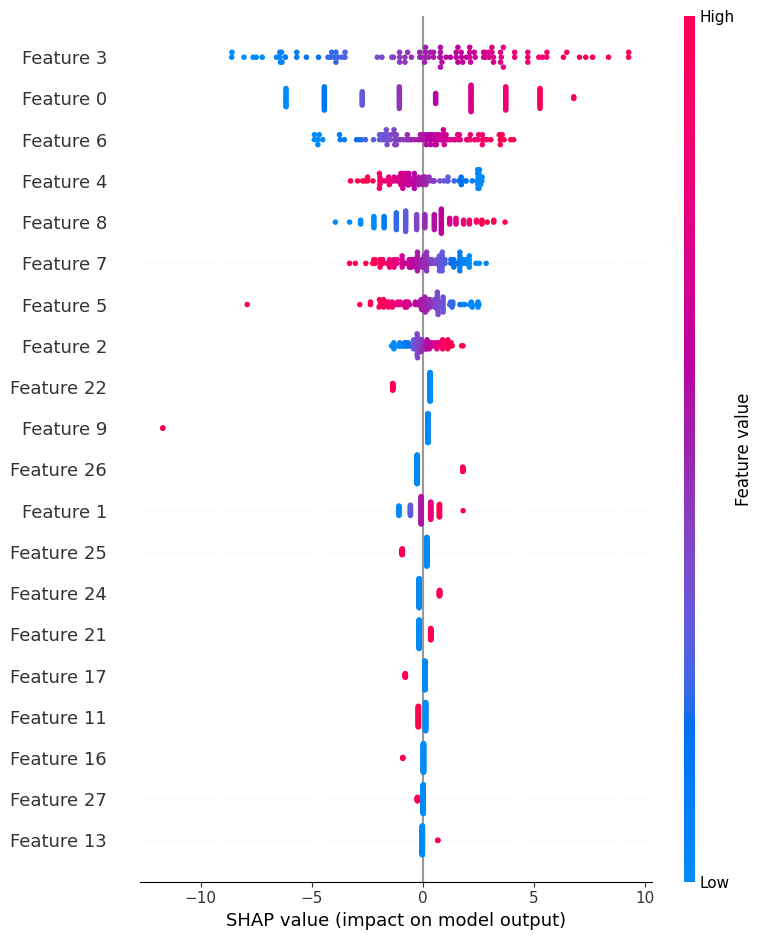

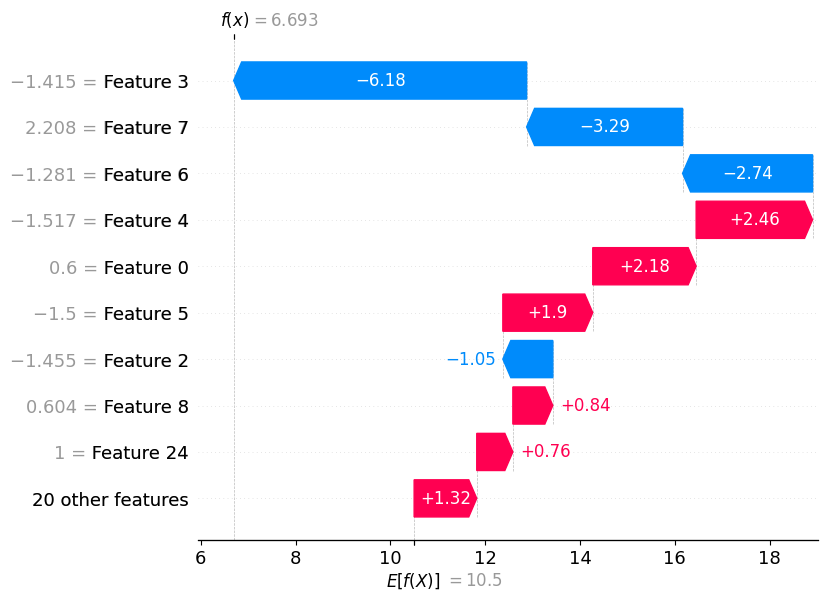

In [129]:
import shap

# Ensuring X_test is processed before SHAP
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Creating SHAP explainer
explainer = shap.Explainer(best_model.named_steps['regressor'], X_test_transformed)

# Generating SHAP values
shap_values = explainer(X_test_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_transformed)

# SHAP Waterfall Plot (First Sample)
shap.plots.waterfall(shap_values[0])



*(Answer here.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.